In [3]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
from PIL import Image
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
# Keras NN:
from keras.utils import to_categorical
# My utils:
from codvidutils.imageproc import map_categorical
from codvidutils.cudasession import set_session
from codvidutils import nwpic as nw
from codvidutils.Transformation_class import Transformation

In [4]:
trns = Transformation('data/train_split_v4.csv', 'data/test_split_v4.csv')
#------------Read images and prepare dataset------------#
train_class, test_class = trns.read_imgs_paths()
X_train, X_test, diseaseID_train, diseaseID_test = trns.read_imgs(train_class, test_class)
del train_class, test_class
#------------Imbalanced methods------------#
X_train, X_test, diseaseID_train = trns.underbalance(X_train, X_test, diseaseID_train)
print('X_train.shape: {}\nX_test.shape: {}'.format(X_train.shape, X_test.shape))
print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)
X_train, X_test, diseaseID_train, diseaseID_test = trns.new_imgs(X_train, X_test, diseaseID_train, diseaseID_test)
Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0
X_test = X_test/255
X_train = X_train/255

You are going to read from: data/train_split_v4.csv and data/test_split_v4.csv
Total number of images: 1540
shape X: 13600 1540,  disease_ID (Y): 13600 1540
Count of classes:  Counter({0: 7966, 2: 5447, 1: 187})
New diseaseID shape:  (9097,)
New X shape:  (9097, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 97})
Undersample shapes:
diseaseID_train.shape: (9097,)
X_train.shape: (9097, 120000)
X_train.shape: (9097, 200, 200, 3)
X_test.shape: (1540, 200, 200, 3)
Normal train:  (4500,)
Pneumonia train:  (4500,)
COVID train:  (97,)
*******************************************************
Normal test:  (885,)
Pneumonia test:  (591,)
COVID test:  (64,)
(2425, 180, 180, 3)
(2425,)
X_train.shape:  (11522, 180, 180, 3)
diseaseID_train.shape:  (11522,)
X_test_news.shape:  (1600, 180, 180, 3)
diseaseID_test_news.shape:  (1600,)
X_test.shape:  (3140, 180, 180, 3)
diseaseID_test.shape:  (3140,)


## Neural network

In [5]:
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [9]:
input_img = Input(shape=X_train.shape[1:])
encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(128, (3, 3), activation='relu', padding='same')(encoder)
encoder = MaxPooling2D((2,2), padding='same')(encoder)
encoder = Conv2D(256, (3, 3), activation='relu', padding='same')(encoder)

decoder = Conv2D(64, (3,3), activation='relu', padding='same')(encoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(128, (3, 3), activation='relu', padding='same')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(256, (3, 3), activation='relu')(decoder)
decoder = UpSampling2D((2, 2))(decoder)
decoder = Conv2D(3, (3, 3), activation='relu', padding='same')(decoder)

autoencoder = Model(input_img, decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 128)       0   

In [10]:
best_model_path = 'Autoencoder_covid_v4.hdf5'
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
amsgrad = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
autoencoder.compile(optimizer=amsgrad, loss='mse', metrics=['acc', 'mse'])
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=False, callbacks=[checkpoint],
                          validation_data=(X_test, X_test))

Train on 11522 samples, validate on 3140 samples
Epoch 1/10
11522/11522 [==============================] - 68s 6ms/step - loss: 0.0277 - acc: 0.3585 - mse: 0.0277 - val_loss: 0.0019 - val_acc: 0.4016 - val_mse: 0.0019

Epoch 00001: loss improved from inf to 0.02767, saving model to Autoencoder_covid_v4.hdf5
Epoch 2/10
11522/11522 [==============================] - 63s 5ms/step - loss: 0.0016 - acc: 0.3719 - mse: 0.0016 - val_loss: 0.0014 - val_acc: 0.4027 - val_mse: 0.0014

Epoch 00002: loss improved from 0.02767 to 0.00163, saving model to Autoencoder_covid_v4.hdf5
Epoch 3/10
11522/11522 [==============================] - 63s 5ms/step - loss: 0.0013 - acc: 0.3779 - mse: 0.0013 - val_loss: 0.0013 - val_acc: 0.3970 - val_mse: 0.0013

Epoch 00003: loss improved from 0.00163 to 0.00133, saving model to Autoencoder_covid_v4.hdf5
Epoch 4/10
11522/11522 [==============================] - 67s 6ms/step - loss: 0.0012 - acc: 0.3793 - mse: 0.0012 - val_loss: 0.0011 - val_acc: 0.6184 - val_mse: 0

In [6]:
best_model_path = 'Autoencoder_covid_v4.hdf5'
model = load_model(best_model_path)
encoder = Model(model.layers[0].input, model.layers[6].output)
encoder_imgs = encoder.predict(X_test)
decoder_imgs = model.predict(X_test)
encoder_imgs.shape

(3140, 23, 23, 128)

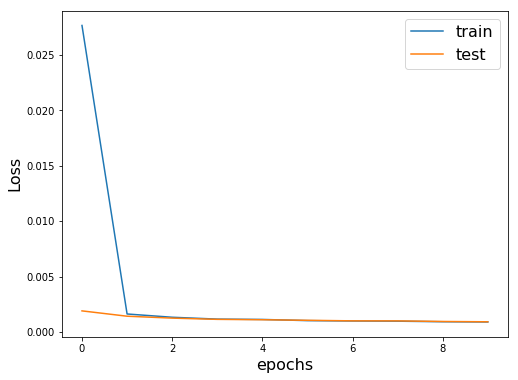

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)
fig.savefig('Figures/Loss.png', dpi=200)

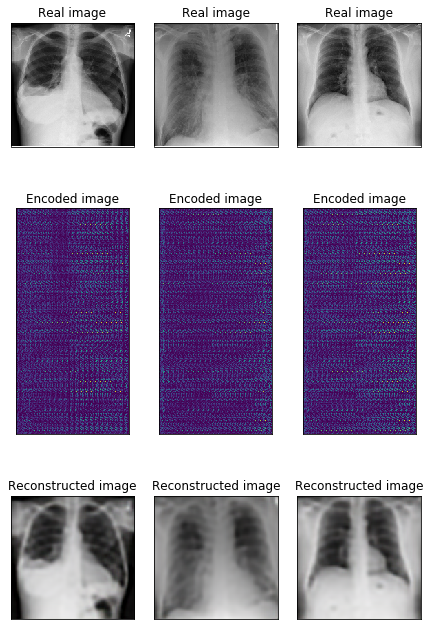

In [26]:
plt.figure(figsize=(20, 10))
for it in range(3):
    i = np.random.randint(0, len(encoder_imgs))
    ax = plt.subplot(3, 10, it+1)
    ax.imshow(X_test[i])
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Real image')
    ax2 = plt.subplot(3, 10, it + 1 + 10)
    ax2.imshow(encoder_imgs[i].reshape(23*8, 23*16).T)
    plt.xticks(())
    plt.yticks(())
    ax2.set_title('Encoded image')
    ax3 = plt.subplot(3, 10, it + 1 + 2*10)
    ax3.imshow(decoder_imgs[i])
    plt.xticks(())
    plt.yticks(())
    ax3.set_title('Reconstructed image')
    plt.tight_layout()
    plt.savefig('Figures/Autoencoder_Reconstruction.png', dpi=200)